In [1]:
import os

import alphashape
import gmsh
import h5py
import matplotlib.pyplot as plt
import meshio
import numpy as np
import shapely
import warnings

from concavehull import concavehull
from descartes import PolygonPatch
from dolfinx import cpp, fem, io, mesh, nls, plot
from mpi4py import MPI
from petsc4py import PETSc

import commons, geometry, grapher
warnings.simplefilter('ignore')

### 2D Irregular Surface

In [2]:
def mesh_surface(coords, xmax=470, ymax=470):
    points = {}
    new_points = {}
    count = 0
    for row in coords:
        points[(row[0], row[1])] = count
        count += 1
    points_set = set(points.keys())
    no_full_neighbors = set()
    triangles = []
    for (x0, y0) in points_set:
        p0 = points[(x0, y0)]
        neighbors = [
            (int(x0 + 1), y0),
            (int(x0 + 1), int(y0 + 1)),
            (x0, int(y0 + 1))
        ]
        neighbor_points = [p0]
        for p in neighbors:
            v = points.get(p)
            neighbor_points.append(v)

        midpoint = (x0 + 0.5, y0 + 0.5)
        if midpoint[0] > xmax or midpoint[1] > ymax:
            continue
        points[midpoint] = count
        p2 = count
        count += 1
        for i in range(4):
            p0 = neighbor_points[i]
            if i == 3:
                p1 = neighbor_points[0]
            else:
                p1 = neighbor_points[i + 1]
            if not p0 is None and not p1 is None:
                triangles.append(
                    (p0, p1, p2)
                )
                

    return triangles, points

In [3]:
img = np.asarray(plt.imread('data/current_constriction/test11.tif')[:, :, 0], dtype=np.uint8)
coords = np.asarray(np.argwhere(img == 1), dtype=np.int32)

In [4]:
triangles, points = mesh_surface(coords)
cell_types = commons.CellTypes()
cell_type = cell_types.triangle
cells = np.asarray(triangles, dtype=np.int32)
max_row_idx = max(points.values())
new_points = np.zeros((max_row_idx + 1, 2))

for k, v in points.items():
    new_points[v, :] = k
cell_data = np.zeros((len(triangles),), dtype=np.int32).tolist()
out_mesh = meshio.Mesh(points=new_points, cells={cell_type: cells}, cell_data={"name_to_read": [cell_data]})
out_mesh.write("trial.xdmf")

### 3D Surface Marking

In [5]:
# outdir = 'mesh/study_4/26-26-7.25/0.5'
# outdir = 'mesh/1/051-051-051_000-000-000'
# tria_meshname = f'{outdir}/tria.xdmf'
# tetr_meshname = f'{outdir}/tetr.xdmf'

# with io.XDMFFile(MPI.COMM_WORLD, f"{tetr_meshname}", "r") as infile3:
#     domain = infile3.read_mesh(cpp.mesh.GhostMode.none, 'Grid')
#     ct = infile3.read_meshtags(domain, name="Grid")
# domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim - 1)
# with io.XDMFFile(MPI.COMM_WORLD, f"{tria_meshname}", "r") as infile3:
#     surf = infile3.read_mesh(cpp.mesh.GhostMode.none, 'Grid')
#     ft = infile3.read_meshtags(domain, name="Grid")

In [6]:
# surfaces = mesh.locate_entities_boundary(domain, 2, lambda x: np.isreal(x[1]))

In [7]:
# news = mesh.locate_entities_boundary(domain, 0, lambda x: np.isreal(x[1]))

In [8]:
# (surfaces.shape, news.shape, mesh.exterior_facet_indices(domain.topology).shape)

In [9]:
# data3 = h5py.File(tetr_meshname.replace(".xdmf", ".h5"), "r")
# data2 = h5py.File(tria_meshname.replace(".xdmf", ".h5"), "r")

### Irregular Surface Using gmsh

In [10]:
coords = np.asarray(np.argwhere(img == 1), dtype=np.int32)
xmax = 470
ymax = 470
all_points = {}
corner_points = [
    (0, 0, 0),
    (xmax, 0, 0),
    (xmax, ymax, 0),
    (0, ymax, 0)
]
other_points = []
count = 0
for row in coords:
    all_points[(row[0], row[1])] = count
    count += 1
gmsh_points = []
points_view = {int(v): (int(k[0]), int(k[1])) for k, v in all_points.items()}

In [11]:
graph = grapher.PixelGraph(points=points_view)
graph.build_graph()
graph.get_graph_pieces()
graph.n_pieces

122

(2, 1) (5.5555555555555545, 48.5, 0.0)
(2, 2) (24.501115416226376, 417.61465304684754, 0.0)
(2, 3) (54.33148693093301, 39.05221856788413, 0.0)
(2, 4) (114.67809138633264, 271.3832993447923, 0.0)
(2, 5) (115.27453881819079, 22.072901252836143, 0.0)
(2, 6) (140.05197132616487, 45.05913978494624, 0.0)
(2, 7) (152.0880829015544, 46.45423143350604, 0.0)
(2, 8) (167.78175618073317, 8.21696504688832, 0.0)
(2, 9) (171.99384993849938, 39.60516605166052, 0.0)
(2, 10) (203.68587360594796, 398.3135068153656, 0.0)
(2, 11) (253.59351719765414, 407.0442225392297, 0.0)
(2, 12) (223.31225296442688, 347.77997364953893, 0.0)
(2, 13) (380.32332205485955, 149.30893002556166, 0.0)
(2, 14) (248.99166666666665, 20.202083333333334, 0.0)
(2, 15) (262.323488045007, 281.6694796061885, 0.0)
(2, 16) (291.22352941176473, 13.466666666666667, 0.0)
(2, 17) (295.46781940441883, 284.433237271854, 0.0)
(2, 18) (306.5882352941176, 64.89760348583879, 0.0)
(2, 19) (445.26120857699806, 90.81091617933723, 0.0)
(2, 20) (465.094

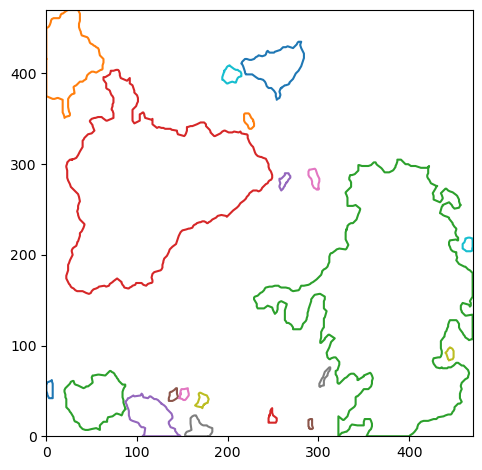

In [37]:
Lx = 470
Ly = 470
Lz = 100
markers = commons.SurfaceMarkers()
gmsh.initialize()
gmsh.model.add('area')
side_loops = []
for p in graph.pieces:
    if len(p) < 50:
        continue
    arr = []
    for c in p:
        arr.append(points_view[c])
    alpha_shape = alphashape.alphashape(arr, 0.25)
    exterior = alpha_shape.exterior
    hull = []
    for c in exterior.coords:
        hull.append((c[0], c[1]))
    hull_arr = np.asarray(hull)
    hull_points = []
    for pp in hull[:-1]:
        hull_points.append(
            gmsh.model.occ.addPoint(int(pp[0]), int(pp[1]), 0)
        )
    gmsh.model.occ.synchronize()
    hull_lines = []
    for i in range(-1, len(hull_points) - 1):
        hull_lines.append(
            gmsh.model.occ.addLine(hull_points[i], hull_points[i + 1])
        )
    gmsh.model.occ.synchronize()
    hull_loop = gmsh.model.occ.addCurveLoop(hull_lines)
    side_loops.append(hull_loop)
surf_pieces = []
for sloop in side_loops:
    surf = gmsh.model.occ.addPlaneSurface((1, sloop))
    surf_pieces.append(surf)
gmsh.model.occ.synchronize()
old_surfaces = gmsh.model.occ.getEntities(dim=2)
gmsh.model.addPhysicalGroup(2, [vv[1] for vv in old_surfaces], markers.left_cc)
box = gmsh.model.occ.addBox(0, 0, 0, Lx, Ly, Lz)
gmsh.model.occ.synchronize()
insulated = []
right = []
other_surf = gmsh.model.occ.cut([(2, 25)], old_surfaces, removeTool=False)
gmsh.model.occ.synchronize()
insulated += [vv[1] for vv in other_surf[0]]
new_surfaces = gmsh.model.occ.getEntities(2)
for surf in new_surfaces:
    com = gmsh.model.occ.getCenterOfMass(surf[0], surf[1])
    if np.isclose(com[2], 0):
        pass
    elif np.isclose(com[2], Lz):
        right.append(surf[1])
    else:
        insulated.append(surf[1])
gmsh.model.addPhysicalGroup(2, right, markers.right_cc)
gmsh.model.addPhysicalGroup(2, insulated, markers.insulated)
gmsh.model.occ.synchronize()
vols = gmsh.model.occ.getEntities(3)
gmsh.model.addPhysicalGroup(3, [vols[0][1]])
gmsh.model.occ.synchronize()
gmsh.model.mesh.generate(3)
gmsh.write("trial.msh")
gmsh.finalize()

In [ ]:
gmsh.initialize()
gmsh.model.add('trial')
box = gmsh.model.occ.addBox(0, 0, 0, 100, 100, 100)
gmsh.model.occ.synchronize()
new_surfaces = gmsh.model.occ.getEntities(2)
for surf in new_surfaces:
    com = gmsh.model.occ.getCenterOfMass(surf[0], surf[1])
    print(surf, com)
gmsh.finalize()